- https://mgjeon.github.io/posts/semantic-segmentation-fcn-resnet50/
- https://github.com/mgjeon/semantic-segmentation-pytorch

## Semantic Segmentation

In this post, I perform binary semantic segmentation in PyTorch using a Fully Convolutional Network (FCN) with a ResNet-50 backbone. The model is pre-trained on a subset of COCO using only the 20 categories from the Pascal VOC dataset, and I fine-tune it on the balloon dataset from the Mask R-CNN repository.

I referred to the [code for balloon dataset of Mask R-CNN repository](https://github.com/matterport/Mask_RCNN/blob/master/samples/balloon/balloon.py) and the [colab tutorial of detectron2](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5) for the balloon dataset; and the [torchvision semantic segmentaion reference training scripts](https://github.com/pytorch/vision/tree/main/references/segmentation) for the overall code structure.

## Balloon dataset

Download the balloon dataset from [Mask R-CNN repository](https://github.com/matterport/Mask_RCNN) and transform it into a format that is compatible with the binary semantic segmentation task.

```
dataset
├── train
│   ├── images
│   │   ├── <file1>.png
│   │   ├── <file2>.png
│   │   └── ...
│   └── masks
│       ├── <file1>.png
│       ├── <file2>.png
│       └── ...
└── val
    ├── images
    │   ├── <file1>.png
    │   ├── <file2>.png
    │   └── ...
    └── masks
        ├── <file1>.png
        ├── <file2>.png
        └── ...
```

Download the dataset as an zip file.

In [ ]:
import requests

url = "https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip"
filename = "balloon_dataset.zip"

response = requests.get(url)
with open(filename, "wb") as file:
    file.write(response.content)

Extract the zip file.

In [ ]:
import zipfile

with zipfile.ZipFile(filename, "r") as file:
    file.extractall()

Remove the unnecessary folder.

In [ ]:
import shutil

shutil.rmtree("__MACOSX")

Convert the dataset into the binary semantic segmentation format.

In [ ]:
import json
from pathlib import Path
import numpy as np
from PIL import Image
import skimage.draw

def create_mask(dataset_dir, new_dataset_dir):
    dataset_dir = Path(dataset_dir)

    img_dir = Path(new_dataset_dir) / "images"
    mask_dir = Path(new_dataset_dir) / "masks"
    img_dir.mkdir(parents=True, exist_ok=True)
    mask_dir.mkdir(parents=True, exist_ok=True)

    with open(dataset_dir / "via_region_data.json") as file:
        annotations = json.load(file)

    for idx, v in enumerate(annotations.values()):
        img = np.array(Image.open(dataset_dir / v["filename"]).convert("RGB"))
        height, width = img.shape[:2]

        regions = v["regions"]

        mask = np.zeros([height, width], dtype=np.uint8)
        for region in regions.values():
            anno = region["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = np.array([[y, x] for x, y in zip(px, py)])
            mask += skimage.draw.polygon2mask((height, width), poly)
        mask = mask.astype(np.bool).astype(np.uint8)

        Image.fromarray(img).save(img_dir / (v["filename"][:-4] + ".png"))
        Image.fromarray(mask).save(mask_dir / (v["filename"][:-4] + ".png"))

In [ ]:
create_mask("balloon/train", "dataset/train")
create_mask("balloon/val", "dataset/val")

## Dataset

In [ ]:
from pathlib import Path

from torch.utils.data import Dataset
from torchvision import tv_tensors
from torchvision.io import read_image

class BalloonDataset(Dataset):
    def __init__(self, dataset_dir, transform=None):

        self.dataset_dir = Path(dataset_dir)
        self.transform = transform

        self.img_dir = self.dataset_dir / "images"
        self.mask_dir = self.dataset_dir / "masks"

        self.imgs = list(self.img_dir.glob("*.png"))


    def __len__(self):
        return len(self.imgs)


    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        mask_path = self.mask_dir / img_path.name

        img = read_image(img_path)
        mask = read_image(mask_path)[0]

        img = tv_tensors.Image(img)
        mask = tv_tensors.Mask(mask)

        sample = {
            "image": img,
            "mask": mask
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmp = ListedColormap(['black','white'])

<class 'torchvision.tv_tensors._image.Image'>
torch.Size([3, 1625, 2048])
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)

<class 'torchvision.tv_tensors._mask.Mask'>
torch.Size([1625, 2048])
tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


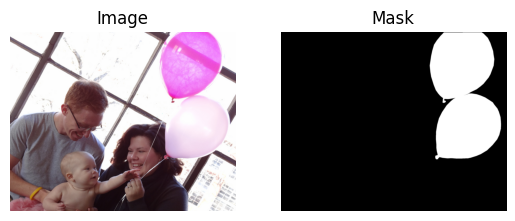

In [ ]:
dataset = BalloonDataset("dataset/train")

sample = dataset[0]

print(type(sample["image"]))
print(sample["image"].shape)
print(sample["image"].min(), sample["image"].max())

print()

print(type(sample["mask"]))
print(sample["mask"].shape)
print(sample["mask"].min(), sample["mask"].max())

plt.subplot(1,2,1)
plt.imshow(sample["image"].permute(1,2,0))
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(sample["mask"], cmap=cmp)
plt.title("Mask")
plt.axis("off")
plt.show()

<class 'torchvision.tv_tensors._image.Image'>
torch.Size([3, 675, 1024])
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)

<class 'torchvision.tv_tensors._mask.Mask'>
torch.Size([675, 1024])
tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


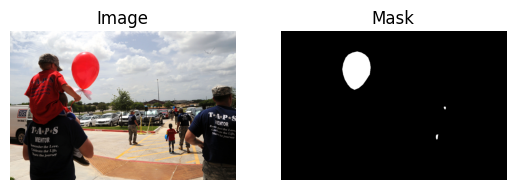

In [ ]:
dataset = BalloonDataset("dataset/val")

sample = dataset[0]

print(type(sample["image"]))
print(sample["image"].shape)
print(sample["image"].min(), sample["image"].max())

print()

print(type(sample["mask"]))
print(sample["mask"].shape)
print(sample["mask"].min(), sample["mask"].max())

plt.subplot(1,2,1)
plt.imshow(sample["image"].permute(1,2,0))
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(sample["mask"], cmap=cmp)
plt.title("Mask")
plt.axis("off")
plt.show()

## Transforms

In [ ]:
import torch
from torchvision.transforms import v2

In [ ]:
mean = (0.485, 0.456, 0.406) # ImageNet
std = (0.229, 0.224, 0.225) # ImageNet

base_size = 520

crop_size = 480
hflip_prob = 0.5

transform_train = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize(size=(base_size, base_size)),
        v2.RandomHorizontalFlip(p=hflip_prob),
        v2.RandomCrop(size=(crop_size, crop_size)),
        v2.ToDtype(dtype={tv_tensors.Image:torch.float32, tv_tensors.Mask:torch.int64, "others":None}, scale=True),
        v2.Normalize(mean=mean, std=std), 
        v2.ToPureTensor()
    ]
)

transform_val = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize(size=base_size),
        v2.ToDtype(dtype={tv_tensors.Image:torch.float32, tv_tensors.Mask:torch.int64, "others":None}, scale=True),
        v2.Normalize(mean=mean, std=std), # ImageNet mean and std
        v2.ToPureTensor()
    ]
)

In [ ]:
dataset = BalloonDataset("dataset/train", transform=transform_train)
dataset_val = BalloonDataset("dataset/val", transform=transform_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9131652..2.64].


<class 'torch.Tensor'>
torch.Size([3, 480, 480])
tensor(-1.9132) tensor(2.6400)

<class 'torch.Tensor'>
torch.Size([480, 480])
tensor(0) tensor(1)


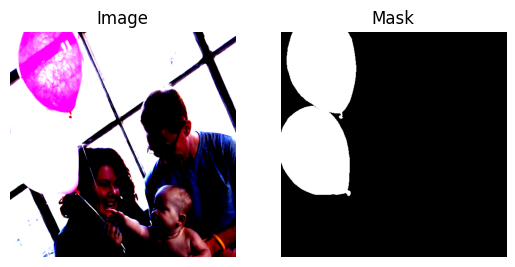

In [ ]:
sample = dataset[0]

print(type(sample["image"]))
print(sample["image"].shape)
print(sample["image"].min(), sample["image"].max())

print()

print(type(sample["mask"]))
print(sample["mask"].shape)
print(sample["mask"].min(), sample["mask"].max())

plt.subplot(1,2,1)
plt.imshow(sample["image"].permute(1,2,0))
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(sample["mask"], cmap=cmp)
plt.title("Mask")
plt.axis("off")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


<class 'torch.Tensor'>
torch.Size([3, 520, 788])
tensor(-2.1179) tensor(2.6400)

<class 'torch.Tensor'>
torch.Size([520, 788])
tensor(0) tensor(1)


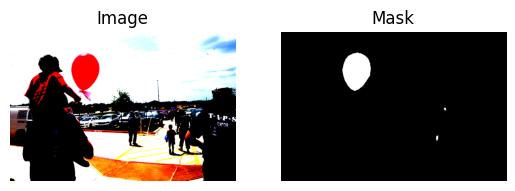

In [ ]:
sample = dataset_val[0]

print(type(sample["image"]))
print(sample["image"].shape)
print(sample["image"].min(), sample["image"].max())

print()

print(type(sample["mask"]))
print(sample["mask"].shape)
print(sample["mask"].min(), sample["mask"].max())

plt.subplot(1,2,1)
plt.imshow(sample["image"].permute(1,2,0))
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(sample["mask"], cmap=cmp)
plt.title("Mask")
plt.axis("off")
plt.show()

## DataLoader

In [ ]:
num_workers = 0
batch_size = 2

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

def collate_fn(batch):
    images = torch.stack([sample["image"] for sample in batch])
    masks = torch.stack([sample["mask"] for sample in batch])
    return images, masks

data_loader = DataLoader(dataset, 
                         batch_size=batch_size, 
                         sampler=RandomSampler(dataset),
                         num_workers=num_workers, 
                         drop_last=True,
                         collate_fn=collate_fn)

data_loader_val = DataLoader(dataset_val,
                             batch_size=1,
                             sampler=SequentialSampler(dataset_val),
                             num_workers=num_workers,
                             drop_last=False,
                             collate_fn=collate_fn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.622571].


torch.Size([2, 3, 480, 480]) torch.Size([2, 480, 480])
torch.float32 torch.int64
tensor([0, 1])


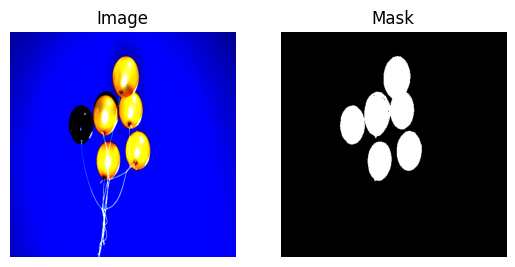

In [ ]:
batch = next(iter(data_loader))
print(batch[0].shape, batch[1].shape)
print(batch[0].dtype, batch[1].dtype)
print(torch.unique(batch[1]))

plt.subplot(1,2,1)
plt.imshow(batch[0][0].permute(1,2,0))
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(batch[1][0], cmap=cmp)
plt.title("Mask")
plt.axis("off")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


torch.Size([1, 3, 520, 788]) torch.Size([1, 520, 788])
torch.float32 torch.int64
tensor([0, 1])


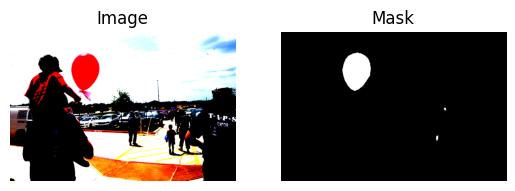

In [ ]:
batch = next(iter(data_loader_val))
print(batch[0].shape, batch[1].shape)
print(batch[0].dtype, batch[1].dtype)
print(torch.unique(batch[1]))

plt.subplot(1,2,1)
plt.imshow(batch[0][0].permute(1,2,0))
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(batch[1][0], cmap=cmp)
plt.title("Mask")
plt.axis("off")
plt.show()

## Model

In [ ]:
import torchvision
from torch.nn import Conv2d

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 2

model_name = "fcn_resnet50"
model_weights = "COCO_WITH_VOC_LABELS_V1"
aux_loss = True

In [ ]:
model = torchvision.models.get_model(
    name=model_name,
    weights=model_weights,
    aux_loss=aux_loss,
)

out_in_channels = model.classifier[4].in_channels
model.classifier[4] = Conv2d(out_in_channels, num_classes, kernel_size=(1, 1), stride=(1, 1))

aux_in_channels = model.aux_classifier[4].in_channels
model.aux_classifier[4] = Conv2d(aux_in_channels, num_classes, kernel_size=(1, 1), stride=(1, 1))

model = model.to(device)

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /home/usr/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:02<00:00, 56.0MB/s] 


In [ ]:
model

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].


odict_keys(['out', 'aux'])
torch.Size([2, 2, 480, 480])
torch.Size([2, 2, 480, 480])
torch.Size([2, 3, 480, 480]) torch.Size([2, 480, 480])
torch.Size([2, 480, 480]) torch.Size([2, 480, 480])
torch.Size([2, 2, 480, 480]) torch.Size([2, 2, 480, 480])


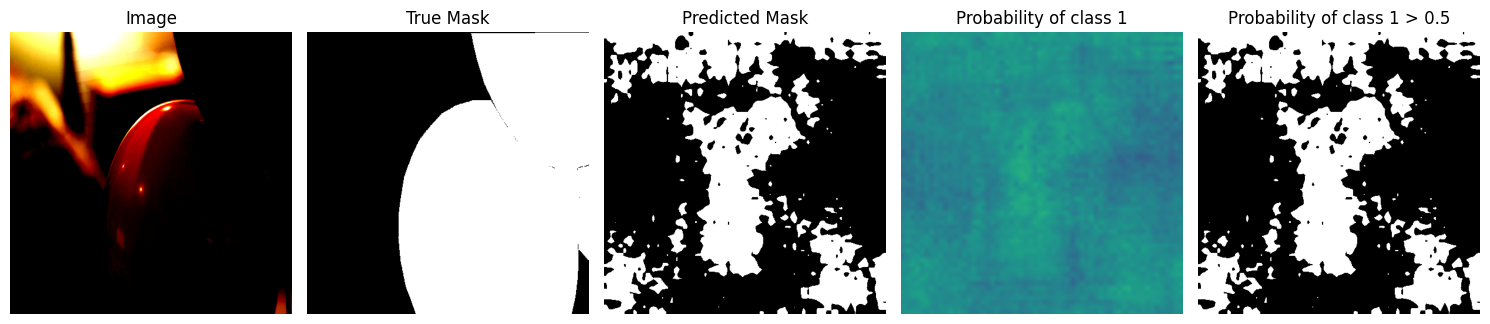

In [ ]:
with torch.inference_mode():
    image, target = next(iter(data_loader))
    image, target = image.to(device), target.to(device)
    output = model(image)

    print(output.keys())

    print(output["out"].shape)
    print(output["aux"].shape)

    output = output["out"]

    image = image.detach().cpu()
    true_mask = target.detach().cpu()
    pred_mask = output.argmax(1).detach().cpu()
    probs = output.softmax(1).detach().cpu()

print(image.shape, target.shape)
print(true_mask.shape, pred_mask.shape)
print(output.shape, probs.shape)

p = 0.5

plt.figure(figsize=(15, 5))

plt.subplot(1,5,1)
plt.imshow(image[0].permute(1,2,0))
plt.title("Image")
plt.axis("off")

plt.subplot(1,5,2)
plt.imshow(true_mask[0], cmap=cmp)
plt.title("True Mask")
plt.axis("off")

plt.subplot(1,5,3)
plt.imshow(pred_mask[0], cmap=cmp)
plt.title("Predicted Mask")
plt.axis("off")

plt.subplot(1,5,4)
plt.imshow(probs[0, 1], clim=(0, 1))
plt.title("Probability of class 1")
plt.axis("off")

plt.subplot(1,5,5)
plt.imshow((probs[0, 1] > p).to(torch.bool), cmap=cmp)
plt.title(f"Probability of class 1 > {p}")
plt.axis("off")

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


torch.Size([1, 3, 520, 788]) torch.Size([1, 520, 788])
torch.Size([1, 520, 788]) torch.Size([1, 520, 788])
torch.Size([1, 2, 520, 788]) torch.Size([1, 2, 520, 788])


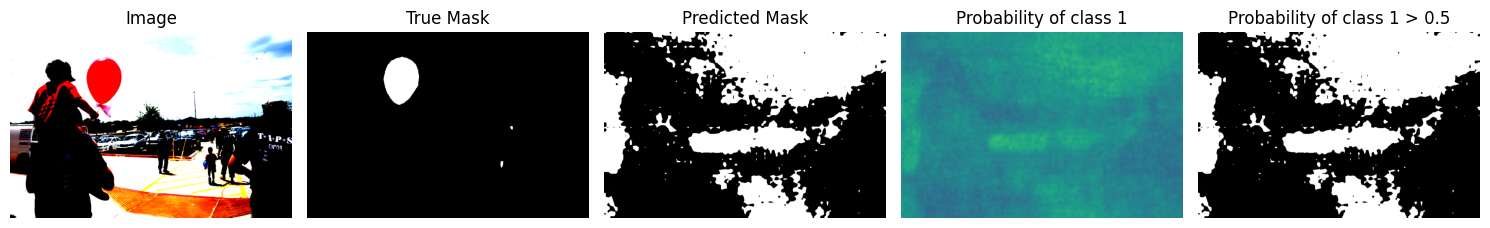

In [ ]:
with torch.inference_mode():
    image, target = next(iter(data_loader_val))
    image, target = image.to(device), target.to(device)
    output = model(image)
    output = output["out"]

    image = image.detach().cpu()
    true_mask = target.detach().cpu()
    pred_mask = output.argmax(1).detach().cpu()
    probs = output.softmax(1).detach().cpu()

print(image.shape, target.shape)
print(true_mask.shape, pred_mask.shape)
print(output.shape, probs.shape)

p = 0.5

plt.figure(figsize=(15, 5))

plt.subplot(1,5,1)
plt.imshow(image[0].permute(1,2,0))
plt.title("Image")
plt.axis("off")

plt.subplot(1,5,2)
plt.imshow(true_mask[0], cmap=cmp)
plt.title("True Mask")
plt.axis("off")

plt.subplot(1,5,3)
plt.imshow(pred_mask[0], cmap=cmp)
plt.title("Predicted Mask")
plt.axis("off")

plt.subplot(1,5,4)
plt.imshow(probs[0, 1], clim=(0, 1))
plt.title("Probability of class 1")
plt.axis("off")

plt.subplot(1,5,5)
plt.imshow((probs[0, 1] > p).to(torch.bool), cmap=cmp)
plt.title(f"Probability of class 1 > {p}")
plt.axis("off")

plt.tight_layout()
plt.show()

## Preparing Training

In [ ]:
lr = 0.01
momentum = 0.9
weight_decay = 1e-4

epochs = 10
print_freq = 5

In [ ]:
params = [
    {"params": [p for p in model.backbone.parameters() if p.requires_grad]},
    {"params": [p for p in model.classifier.parameters() if p.requires_grad]},
    {"params": [p for p in model.aux_classifier.parameters() if p.requires_grad]},
]

In [ ]:
optimizer = torch.optim.SGD(params, 
                            lr=lr, 
                            momentum=momentum, 
                            weight_decay=weight_decay)

In [ ]:
iters_per_epoch = len(data_loader)
iters_per_epoch

30

In [ ]:
lr_scheduler = torch.optim.lr_scheduler.PolynomialLR(
    optimizer, 
    total_iters=iters_per_epoch * epochs, 
    power=0.9
)

In [ ]:
class ConfusionMatrix:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.mat = None

    def update(self, true, pred):
        n = self.num_classes
        if self.mat is None:
            self.mat = torch.zeros((n, n), dtype=torch.int64, device=true.device)

        with torch.inference_mode():
            # T, P
            # 0, 0 => 2*0 + 0 = 0 True Negative
            # 0, 1 => 2*0 + 1 = 1 False Positive
            # 1, 0 => 2*1 + 0 = 2 False Negative
            # 1, 1 => 2*1 + 1 = 3 True Positive
            k = (true >= 0) & (true < n)
            inds = n * true[k].to(torch.int64) + pred[k]
            self.mat += torch.bincount(inds, minlength=n**2).reshape(n, n)

    def compute(self):
        # Confusion Matrix
        # [[TN, FP],
        #  [FN, TP]]
        h = self.mat.float()

        # TN, TP
        # TN -> Correctly predicted as class 0
        # TP -> Correctly predicted as class 1
        diag = torch.diag(h)

        # Overall accuracy
        # (TN + TP) / (TN + FP + FN + TP)
        acc_global = diag.sum() / h.sum()

        # Actual Negative, Actual Positive
        # (TN + FP) -> Actual Negative -> # of pixels that are class 0
        # (FN + TP) -> Actual Positive -> # of pixels that are class 1
        hsum1 = h.sum(1)

        # Predicted Negative, Predicted Positive
        # (TN + FN) -> Predicted Negative -> # of pixels predicted as class 0
        # (FP + TP) -> Predicted Positive -> # of pixels predicted as class 1
        hsum0 = h.sum(0)

        # Accuracy of class 0, Accuracy of class 1
        # (TN) / (TN + FP) -> Accuracy of class 0 
        # (TN + FP = Actual Negative -> # of pixels that are class 0)
        #
        # (TP) / (FN + TP) -> Accuracy of class 1  
        # (FN + TP = Actual Positive -> # of pixels that are class 1)
        acc = diag / hsum1

        # IoU for class 0, IoU for class 1
        # (TN) / ((TN + FP) + (TN + FN) - TN) => TN / (TN + FP + FN) -> IoU for class 0
        # (TP) / ((FN + TP) + (FP + TP) - TP) => TP / (FN + FP + TP) -> IoU for class 1
        iou = diag / (hsum1 + hsum0 - diag)
        return acc_global, acc, iou

In [ ]:
def evaluate(model, data_loader, device, num_classes):
    model.eval()
    
    confmat = ConfusionMatrix(num_classes)

    with torch.inference_mode():
        for image, target in data_loader:
            image, target = image.to(device), target.to(device)
            output = model(image)
            output = output["out"]

            true_mask = target.flatten()
            pred_mask = output.argmax(1).flatten()

            confmat.update(true_mask, pred_mask)

    acc_global, acc, iou = confmat.compute()
    return acc_global, acc, iou

In [ ]:
def criterion(outputs, target):
    """
    outputs: {"out": [batch_size, num_classes, H, W], "aux": [batch_size, num_classes, H, W]}
    target : [batch_size, M, M]
    """
    losses = {}
    for name, output in outputs.items():
        losses[name] = torch.nn.functional.cross_entropy(output, target, ignore_index=255)

    return losses["out"] + 0.5 * losses["aux"]

In [ ]:
def train_one_epoch(model, criterion, optimizer, data_loader, lr_scheduler, device, print_freq):
    model.train()
    
    for idx, (image, target) in enumerate(data_loader):
        image, target = image.to(device), target.to(device)

        output = model(image)
        loss = criterion(output, target)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lr_scheduler.step()

        if idx % print_freq == 0:
            print(f"iteration: {idx}, loss: {loss.item()}, lr: {optimizer.param_groups[0]['lr']}")

In [ ]:
import datetime
from time import perf_counter

In [ ]:
output_dir = Path("output")
output_dir.mkdir(exist_ok=True, parents=True)

## Training Loop

In [ ]:
start_time = perf_counter()

mean_iou_best = 0

for epoch in range(epochs):
    print(f"epoch: {epoch}")
    
    train_one_epoch(model, criterion, optimizer, data_loader, lr_scheduler, device, print_freq)
    acc_global, acc, iou = evaluate(model, data_loader_val, device, num_classes)

    print("overall accuracy: {:.1f}".format(acc_global.item() * 100))
    print("per-class accuracy: {}".format([f"{i:.1f}" for i in (acc * 100).tolist()]))
    print("per-class IoU: {}".format([f"{i:.1f}" for i in (iou * 100).tolist()]))
    mean_iou = iou.mean().item() * 100
    print("mean IoU: {:.1f}".format(mean_iou))

    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "lr_scheduler": lr_scheduler.state_dict(),
        "epoch": epoch,
    }
    torch.save(model.state_dict(), output_dir / f"model_{epoch}.pth")
    torch.save(checkpoint, output_dir / "checkpoint.pth")

    if mean_iou > mean_iou_best:
        mean_iou_best = mean_iou
        torch.save(model.state_dict(), output_dir / "model_best.pth")

total_time = perf_counter() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f"Training time {total_time_str}")

epoch: 0
iteration: 0, loss: 1.0530387163162231, lr: 0.009969994993878174
iteration: 5, loss: 0.9099328517913818, lr: 0.009819818665965752
iteration: 10, loss: 1.4872009754180908, lr: 0.009669386705882587
iteration: 15, loss: 0.2623429596424103, lr: 0.009518694243963476
iteration: 20, loss: 0.5273847579956055, lr: 0.009367736230317173
iteration: 25, loss: 0.1453678458929062, lr: 0.009216507424802825
overall accuracy: 95.3
per-class accuracy: ['95.3', '95.2']
per-class IoU: ['94.9', '61.1']
mean IoU: 78.0
epoch: 1
iteration: 0, loss: 0.298703134059906, lr: 0.009065002386255556
iteration: 5, loss: 0.39084041118621826, lr: 0.00891321546089
iteration: 10, loss: 0.10675305128097534, lr: 0.008761140769802247
iteration: 15, loss: 0.21014389395713806, lr: 0.008608772195481283
iteration: 20, loss: 0.2142447978258133, lr: 0.008456103367230421
iteration: 25, loss: 0.10360172390937805, lr: 0.008303127645386885
overall accuracy: 98.4
per-class accuracy: ['99.9', '80.3']
per-class IoU: ['98.2', '79.

In [ ]:
print("Best mean IoU: {:.1f}".format(mean_iou_best))

Best mean IoU: 93.1


## Evaluation

In [ ]:
model = torchvision.models.get_model(
    name=model_name,
    weights=model_weights,
    aux_loss=aux_loss,
)

out_in_channels = model.classifier[4].in_channels
model.classifier[4] = Conv2d(out_in_channels, num_classes, kernel_size=(1, 1), stride=(1, 1))

aux_in_channels = model.aux_classifier[4].in_channels
model.aux_classifier[4] = Conv2d(aux_in_channels, num_classes, kernel_size=(1, 1), stride=(1, 1))

model = model.to(device)
model.load_state_dict(torch.load(output_dir / "model_best.pth", map_location=device, weights_only=True))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.3959918].


torch.Size([2, 3, 480, 480]) torch.Size([2, 480, 480])
torch.Size([2, 480, 480]) torch.Size([2, 480, 480])
torch.Size([2, 2, 480, 480]) torch.Size([2, 2, 480, 480])


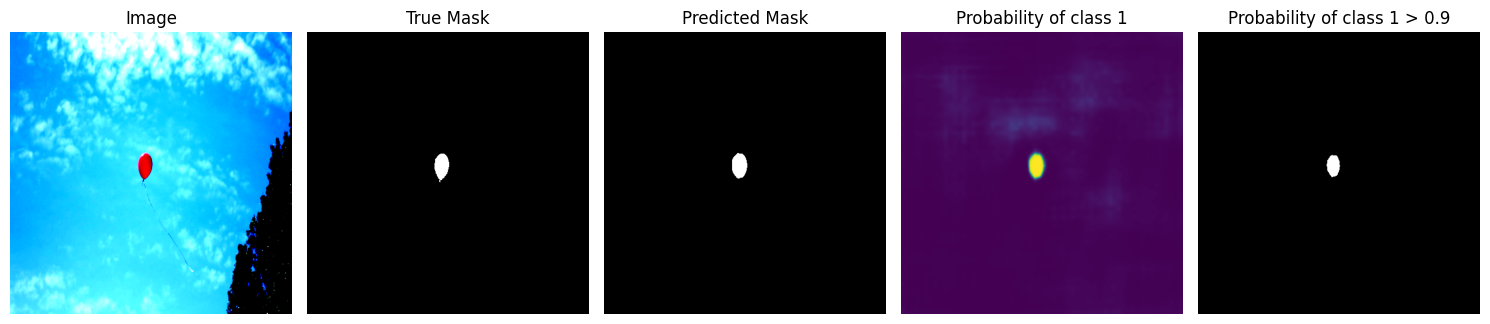

In [ ]:
with torch.inference_mode():
    image, target = next(iter(data_loader))
    image, target = image.to(device), target.to(device)
    output = model(image)
    output = output["out"]

    image = image.detach().cpu()
    true_mask = target.detach().cpu()
    pred_mask = output.argmax(1).detach().cpu()
    probs = output.softmax(1).detach().cpu()

print(image.shape, target.shape)
print(true_mask.shape, pred_mask.shape)
print(output.shape, probs.shape)

p = 0.9

plt.figure(figsize=(15, 5))

plt.subplot(1,5,1)
plt.imshow(image[0].permute(1,2,0))
plt.title("Image")
plt.axis("off")

plt.subplot(1,5,2)
plt.imshow(true_mask[0], cmap=cmp)
plt.title("True Mask")
plt.axis("off")

plt.subplot(1,5,3)
plt.imshow(pred_mask[0], cmap=cmp)
plt.title("Predicted Mask")
plt.axis("off")

plt.subplot(1,5,4)
plt.imshow(probs[0, 1], clim=(0, 1))
plt.title("Probability of class 1")
plt.axis("off")

plt.subplot(1,5,5)
plt.imshow((probs[0, 1] > p).to(torch.bool), cmap=cmp)
plt.title(f"Probability of class 1 > {p}")
plt.axis("off")

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


torch.Size([1, 3, 804, 520]) torch.Size([1, 804, 520])
torch.Size([1, 804, 520]) torch.Size([1, 804, 520])
torch.Size([1, 2, 804, 520]) torch.Size([1, 2, 804, 520])


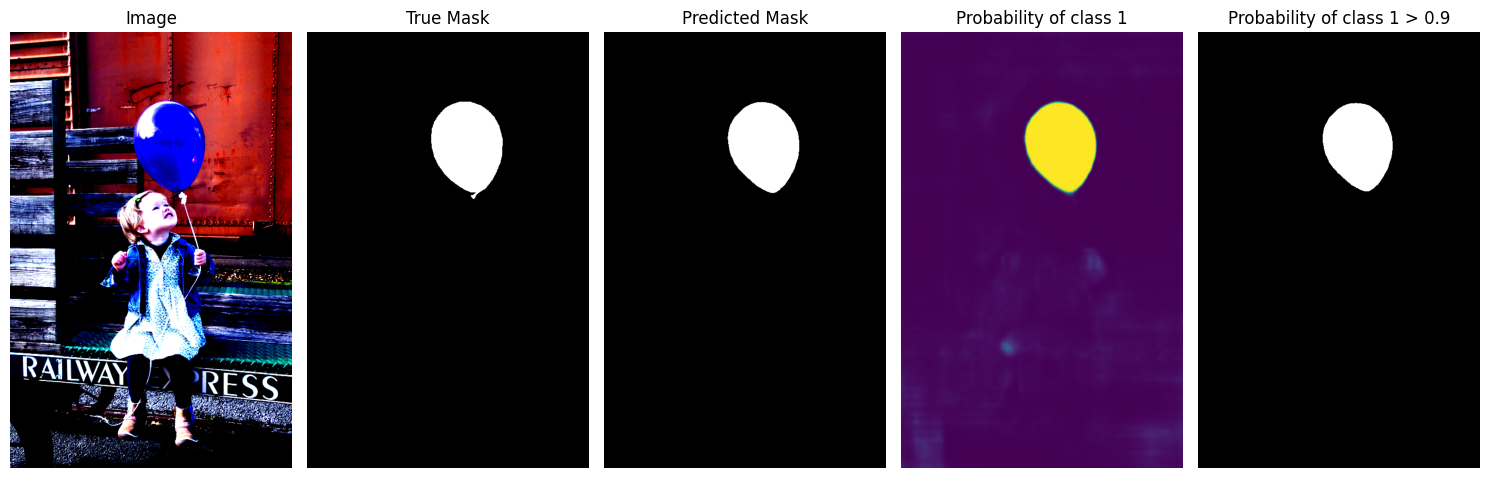

In [ ]:
idx = 4

with torch.inference_mode():
    data_loader_val_iter = iter(data_loader_val)
    for _ in range(idx):
        image, target = next(data_loader_val_iter)
    image, target = image.to(device), target.to(device)
    output = model(image)
    output = output["out"]

    image = image.detach().cpu()
    true_mask = target.detach().cpu()
    pred_mask = output.argmax(1).detach().cpu()
    probs = output.softmax(1).detach().cpu()

print(image.shape, target.shape)
print(true_mask.shape, pred_mask.shape)
print(output.shape, probs.shape)

p = 0.9

plt.figure(figsize=(15, 5))

plt.subplot(1,5,1)
plt.imshow(image[0].permute(1,2,0))
plt.title("Image")
plt.axis("off")

plt.subplot(1,5,2)
plt.imshow(true_mask[0], cmap=cmp)
plt.title("True Mask")
plt.axis("off")

plt.subplot(1,5,3)
plt.imshow(pred_mask[0], cmap=cmp)
plt.title("Predicted Mask")
plt.axis("off")

plt.subplot(1,5,4)
plt.imshow(probs[0, 1], clim=(0, 1))
plt.title("Probability of class 1")
plt.axis("off")

plt.subplot(1,5,5)
plt.imshow((probs[0, 1] > p).to(torch.bool), cmap=cmp)
plt.title(f"Probability of class 1 > {p}")
plt.axis("off")

plt.tight_layout()
plt.show()